In [1]:
import random

#!/bin/python3
import sklearn
#import umap
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_curve, roc_auc_score, accuracy_score, precision_score, silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn import cluster 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from yellowbrick.classifier import ROCAUC

In [2]:
random.seed(10740407)

In [3]:
# Load data:
df = pd.read_csv('musicData.csv')
print(df.shape[0])
# Find the na data entries
df.isna().sum()

50005


instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

In [4]:
# Drop the na rows and find the shape
df=df.dropna()
print(df.shape[0])

50000


In [5]:
# Drop linguistic columns as well as irrelevant ones (date obtained and instance id)
df = df.drop(["instance_id", "artist_name", "track_name", "obtained_date"] , axis=1)

# Find the list of unique key values
keys=df['key'].unique()

# Convert the string key values to integers
i=1
for item in keys:
    df.loc[df['key'] == item, 'key'] = i
    i+=1
    
# Repeat the process done for keys for the modes
modes=df['mode'].unique()
i=1
for item in modes:
    df.loc[df['mode'] == item, 'mode'] = i
    i+=1
    
# Find how many tempo values are missing
df['tempo'].value_counts()['?']

4980

In [6]:
# Create a seperate df with only non-missing tempo values rows, to be used to create a regression to replace the missing tempo values
df_tempo= df[df['tempo'] != '?']

# Create a seperate df with only the missing tempo value rows
df_missing_tempo = df[df['tempo']=='?']

# Create a multi linear regression model and train it on the non-missing tempo data
model=LinearRegression().fit(df_tempo.drop(['tempo', 'music_genre'], axis=1), df_tempo['tempo'].astype(np.float64))
missing_tempo= model.predict(df_missing_tempo.drop(['tempo', 'music_genre'], axis=1))

# Replace the missing tempo values with the predicted tempo values
for i in range(4980):
    df.loc[df['tempo'] == '?', 'tempo'] = missing_tempo[i]
    
# Convert all the tempo values to floats so that the data is usable
df['tempo']=df['tempo'].astype(np.float64)

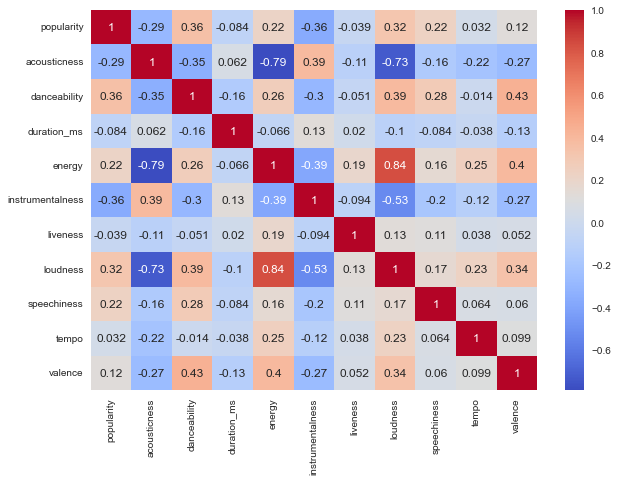

In [7]:
# Create a correlation matrix to have a better sense of the data (what is correlated what isn't etc)
matrix = df.corr().round(3)
fig, ax = plt.subplots(figsize=(10, 7))
ax=sns.heatmap(matrix,annot=True, cmap="coolwarm")
plt.show()

In [8]:
# Create a scaled df to be used for dimensionality reduction, clustering, and the classification model
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['music_genre'], axis=1)))

# Create the set of labels
music_genre = df['music_genre']

In [9]:
# Use t-SNE for dimensionality reduction
X_100=TSNE(n_components=3, verbose=2, perplexity=100, n_iter=1000).fit_transform(df_scaled)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.085s...
[t-SNE] Computed neighbors for 50000 samples in 33.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

Text(0.5, 1.0, 'Perplexity = 100')

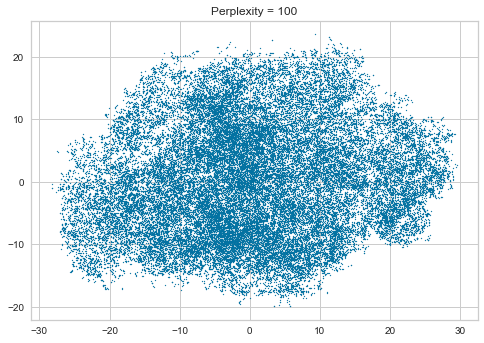

In [10]:
# Graph the 2D (2 component) dimensionality reduction
plt.scatter(X_100[:, 0], X_100[:, 1],s=1)
plt.title('Perplexity = 100')

/var/folders/8x/2s7t54017m79hbqdbp4_92300000gn/T/ipykernel_68909/3381791583.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0.92, 'Perplexity = 100')

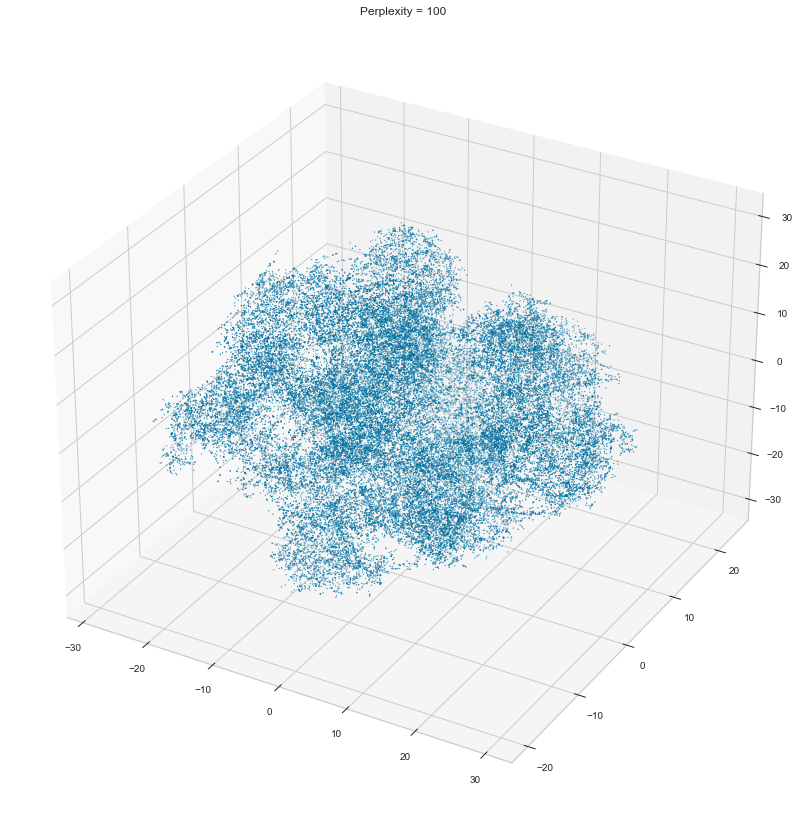

In [11]:
# Graph the 3D (3 component) dimensionality reduction
plt.rcParams['figure.figsize'] = (20, 11)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_100[:, 0], X_100[:, 1], X_100[:, 2], s=1)
ax.set_title('Perplexity = 100')

In [12]:
# List of k values to try
clusters = [2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16]
silhouettes = np.zeros(15)

# Find all the silhouette scores for each k value
for k in clusters:
    kmeans = cluster.KMeans(k)
    labels = kmeans.fit_predict(X_100)
    silhouettes[k-2] = silhouette_score(X_100, labels)

# Print silhouette scores to determine the highest score and what k value to choose
for i in range(15):
    print("k = ", i+2, ": ", silhouettes[i])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/clust

k =  2 :  0.3378344774246216
k =  3 :  0.3361518085002899
k =  4 :  0.32599371671676636
k =  5 :  0.3284071981906891
k =  6 :  0.317007452249527
k =  7 :  0.31099462509155273
k =  8 :  0.3090667128562927
k =  9 :  0.3119833767414093
k =  10 :  0.3211977779865265
k =  11 :  0.3251081705093384
k =  12 :  0.33303168416023254
k =  13 :  0.33313366770744324
k =  14 :  0.33421438932418823
k =  15 :  0.330924928188324
k =  16 :  0.33257362246513367


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/8x/2s7t54017m79hbqdbp4_92300000gn/T/ipykernel_68909/3996912051.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


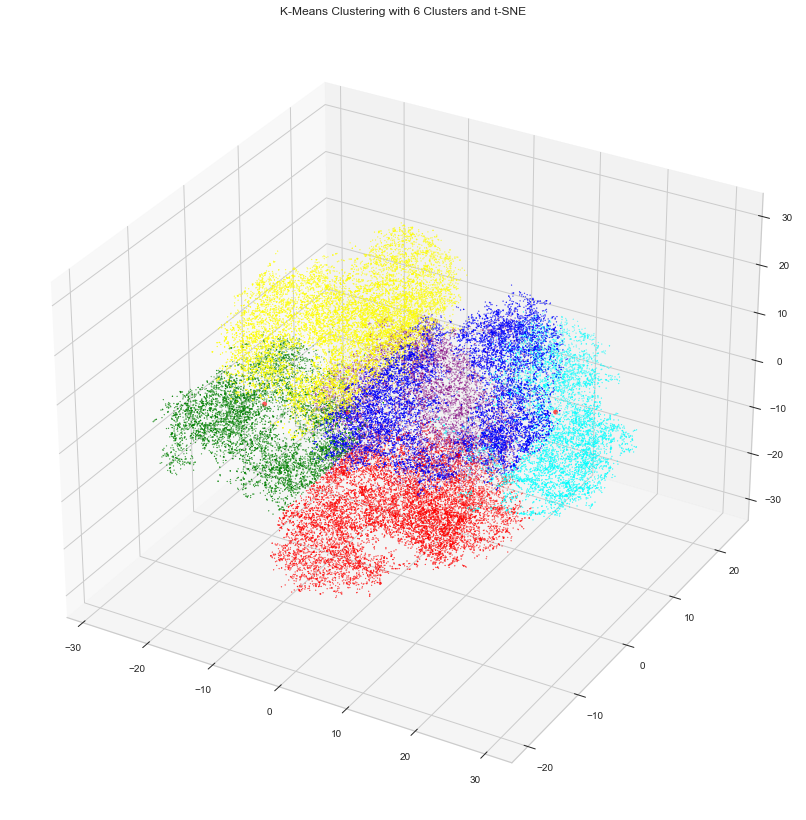

In [31]:
 # Perform k-means clustering with 6 clusters and the initial centroids
kmeans = cluster.KMeans(n_clusters=6).fit(X_100)
labels_6 = kmeans.labels_
centers = kmeans.cluster_centers_

def make_colors(labels):
    # Define a list of visually distinct colors for each cluster
    colors = ['red', 'blue', 'green', 'yellow', 'purple',  'cyan']
    
    # Map each label to a color
    return [colors[label % len(colors)] for label in labels]

colors=make_colors(labels_6)

# Plot the final centroids as white circles
final_centroids = kmeans.cluster_centers_

plt.rcParams['figure.figsize'] = (20, 11)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_100[:, 0], X_100[:, 1], X_100[:, 2], s=1, c=colors)
ax.scatter(final_centroids[:, 0], final_centroids[:, 1], marker='o', color='red')
ax.set_title('K-Means Clustering with 6 Clusters and t-SNE')

# Show the plot
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/8x/2s7t54017m79hbqdbp4_92300000gn/T/ipykernel_68909/3895520464.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


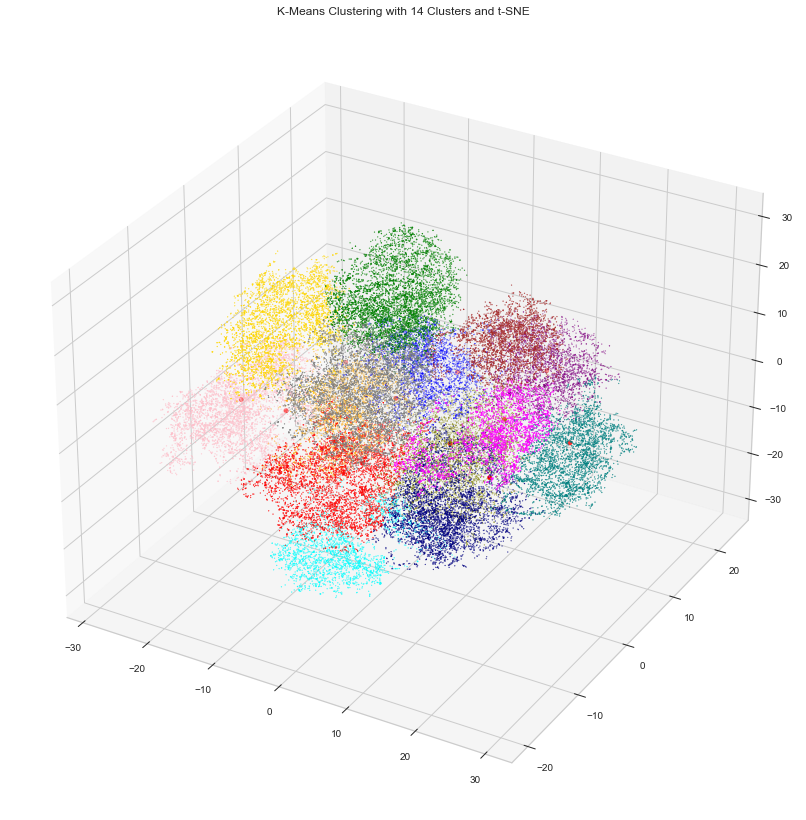

In [17]:
 # Perform k-means clustering with 6 clusters and the initial centroids
kmeans = cluster.KMeans(n_clusters=14).fit(X_100)
labels_14 = kmeans.labels_
centers = kmeans.cluster_centers_

def make_colors(labels):
    # Define a list of visually distinct colors for each cluster
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'gold', 'navy', 'teal']
    
    # Map each label to a color
    return [colors[label % len(colors)] for label in labels]

colors=make_colors(labels_14)

# Plot the final centroids as white circles
final_centroids = kmeans.cluster_centers_

plt.rcParams['figure.figsize'] = (20, 11)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_100[:, 0], X_100[:, 1], X_100[:, 2], s=1, c=colors)
ax.scatter(final_centroids[:, 0], final_centroids[:, 1], marker='o', color='red')
ax.set_title('K-Means Clustering with 14 Clusters and t-SNE')

# Show the plot
plt.show()

In [18]:
# Add the cluster number to the data
df['cluster_6']=labels_6
df['cluster_14']=labels_14

In [21]:
# Normalize all the data to use for the model
data = pd.DataFrame(StandardScaler().fit_transform(df.drop(['music_genre'], axis=1)))
data['music_genre']=music_genre

In [22]:
# Create the test and train sets by iterating through the genres and creating test sizes of 500
genres = df['music_genre'].unique()
train_set = pd.DataFrame()
test_set = pd.DataFrame()

for g in genres:
    genre_df = data.loc[data['music_genre'] == g]
    X_train,  X_test  = train_test_split(genre_df, test_size = 500, random_state=42)
    # Append the individual genre test and train sets to the overall test and train sets
    train_set=train_set.append(X_train)
    test_set=test_set.append(X_test)

In [23]:
# Create the predictor train test sets
X_train=train_set.drop(['music_genre'], axis=1)
X_test= test_set.drop(['music_genre'], axis=1)

# Create the outcome test train sets
Y_train = train_set['music_genre']
Y_test = test_set['music_genre']

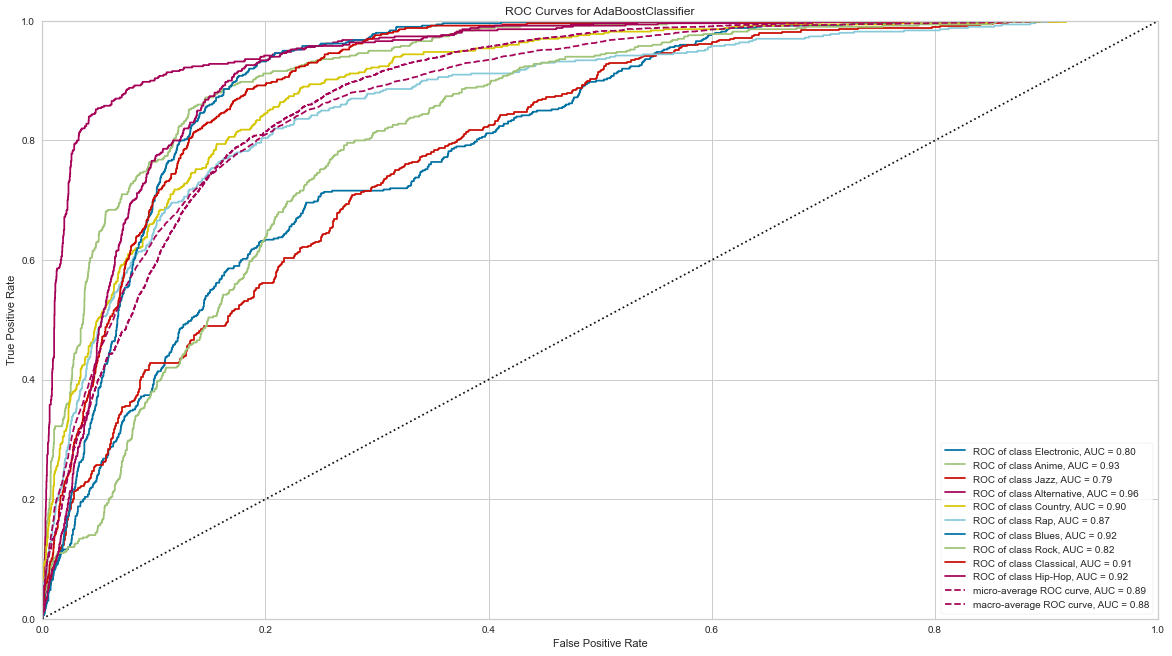

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
# Make and adaboost classifier model
abc = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200, learning_rate=1).fit(X_train, Y_train)

# Use yellowbrick.classifier to plot the ROC curves and calculate the AUCs
rauc = ROCAUC(abc, classes=['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'])
rauc.fit(X_train, Y_train)
score=rauc.score(X_test, Y_test)
rauc.show()